# UNSW-NB 15 dataset

The raw network packets of the [UNSW-NB 15](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/) dataset was created by the IXIA PerfectStorm tool in the Cyber Range Lab of the Australian Centre for Cyber Security (ACCS) for generating a hybrid of real modern normal activities and synthetic contemporary attack behaviours. This notebook prepares information about the dataset and how we can use the data in the TIS project. 

# Interpretation of the Data 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import scipy as sp
import pandas as pd 
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pylab as plt
plt.style.use('ggplot')

from sklearn import preprocessing
from google.colab import drive, files

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# setup the global variables and paths that will be used throughout this document 
# data_path = '../data/'
data_path = '/content/drive/My Drive/Data/UNSWNB15/'
code_path = '/content/drive/My Drive/Colab Notebooks/Projects/TIS-IEEE-2020/'


In [ ]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [ ]:
%%sh
cd /content/drive/My\ Drive/Colab\ Notebooks/Projects/TIS-IEEE-2020/
pwd

/content/drive/My Drive/Colab Notebooks/Projects/TIS-IEEE-2020


# About the Features

We begin by looking into the features and their respective types (e.g., binary, nominal, float, etc). Group the data from by the type of features that exist in the data. We must address how we are going to effectively deal with the different types of features. In particular, we will need to find a way to integrate the nominal features into the machine learning model. 

In [1]:
df_feat = pd.read_csv(data_path + 'NUSW-NB15_features.csv', sep=',')
df_feat.sort_values(by='Type ')

NameError: ignored

# Exploratory Data Analysis (Individual Files)

In [ ]:
fname = '2'

In [ ]:
df = pd.read_csv(data_path + 'UNSW-NB15_' + fname + '.csv', header=None)
df.columns = df_feat['Name'].values.tolist()
df['attack_cat'] = df['attack_cat'].fillna('Normal')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,39,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


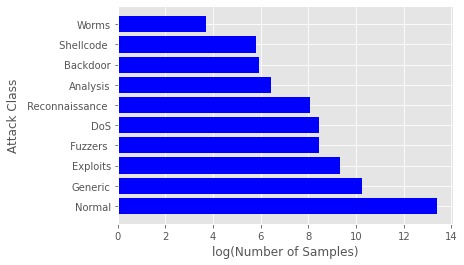

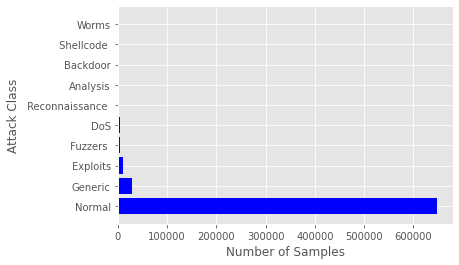

In [ ]:
attacks = np.unique(df['attack_cat'])
n_attacks = np.array([(df['attack_cat']==attack).values.sum() for attack in attacks])
i = np.argsort(n_attacks)[::-1]
n_attacks = n_attacks[i]
attacks = attacks[i]

plt.figure()
plt.barh(attacks, np.log(n_attacks), color='blue')
plt.ylabel('Attack Class')
plt.xlabel('log(Number of Samples)')
plt.savefig(code_path+'figs/unsw-nb15_'+fname+'_log-samples.pdf')

plt.figure()
plt.barh(attacks, n_attacks, color='blue')
plt.ylabel('Attack Class')
plt.xlabel('Number of Samples')
plt.savefig(code_path+'figs/unsw-nb15_'+fname+'_samples.pdf')

# Exploratory Data Analysis (Distriobution of the Classes in the Training / Testing Data)

In [ ]:
df_tr = pd.read_csv(data_path + 'UNSW_NB15_training-set.csv')
df_te = pd.read_csv(data_path + 'UNSW_NB15_testing-set.csv')

In [ ]:
def get_attack_counts(df):
    """
    """
    attacks = np.unique(df['attack_cat'])
    n_attacks = np.array([(df['attack_cat']==attack).values.sum() for attack in attacks])
    sorted_idx = np.argsort(n_attacks)[::-1]
    return sorted_idx, attacks, n_attacks

In [ ]:
sorted_idx_tr, attacks_tr, n_attacks_tr = get_attack_counts(df_tr)
sorted_idx_te, attacks_te, n_attacks_te = get_attack_counts(df_te)

<Figure size 432x288 with 0 Axes>

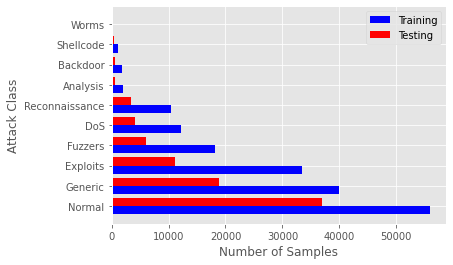

In [ ]:
plt.figure()
fig, axs = plt.subplots()

index = np.arange(len(sorted_idx_tr))-1
bar_width = 0.4
opacity = 1.

rects1 = plt.barh(index, n_attacks_tr[sorted_idx_tr], bar_width, alpha=opacity, color='b', label='Training')
rects2 = plt.barh(index + bar_width, n_attacks_te[sorted_idx_tr], bar_width, alpha=opacity, color='r', label='Testing')

plt.yticks(index + .5*bar_width, tuple(attacks_tr[sorted_idx_tr]))
plt.ylabel('Attack Class')
plt.xlabel('Number of Samples')

plt.legend()

plt.savefig(code_path+'figs/unsw-nb15_samples.pdf')


<Figure size 432x288 with 0 Axes>

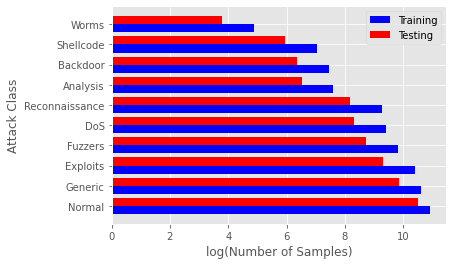

In [ ]:
plt.figure()
fig, axs = plt.subplots()

index = np.arange(len(sorted_idx_tr))-1
bar_width = 0.4
opacity = 1.

rects1 = plt.barh(index, np.log(n_attacks_tr[sorted_idx_tr]), bar_width, alpha=opacity, color='b', label='Training')
rects2 = plt.barh(index + bar_width, np.log(n_attacks_te[sorted_idx_tr]), bar_width, alpha=opacity, color='r', label='Testing')

plt.yticks(index + .5*bar_width, tuple(attacks_tr[sorted_idx_tr]))
plt.ylabel('Attack Class')
plt.xlabel('log(Number of Samples)')

plt.legend(loc='upper right')
plt.savefig(code_path+'figs/unsw-nb15_log-samples.pdf')

# Analysis of the Features & Distributions 

In [ ]:
# print out the keys 
df_tr.keys()

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [ ]:
df_tr.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0


The following code does...

In [ ]:
drop_cols = ['id', 'proto', 'service', 'state', 'attack_cat', 'label', 'is_sm_ips_ports']
# drop_cols = ['id', 'proto', 'service', 'state', 'attack_cat', 'label']

df_tr_feat = df_tr.drop(drop_cols, axis = 1)
X = df_tr_feat.values
labels = df_tr['attack_cat'].values
y = np.zeros((len(X),))

uni_labels = np.unique(labels)
label_dict = {}
for lbl, n in zip(uni_labels, range(len(uni_labels))):
    label_dict[lbl] = n
label_dict['Analysis'] = 6
label_dict['Normal'] = 0


for n in range(len(y)): 
    y[n] = label_dict[labels[n]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_

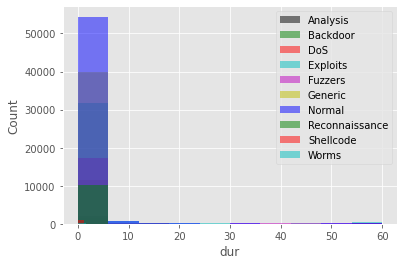

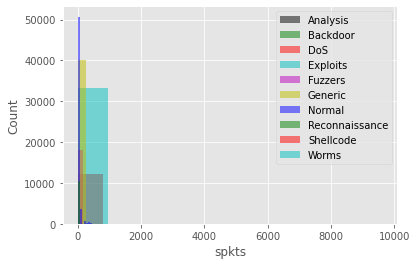

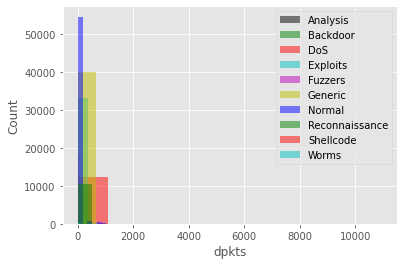

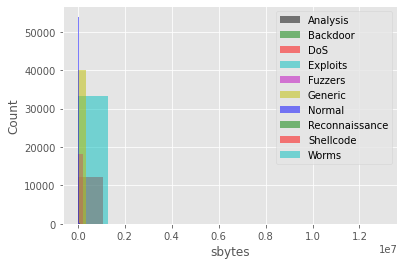

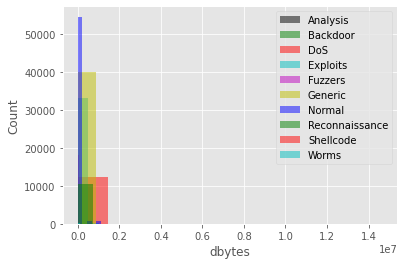

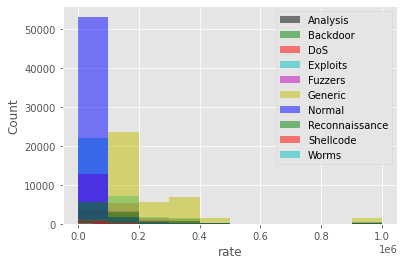

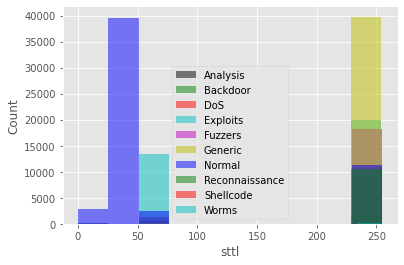

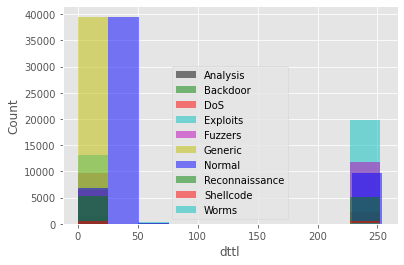

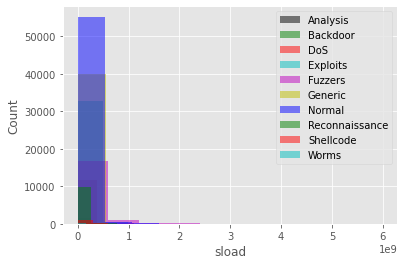

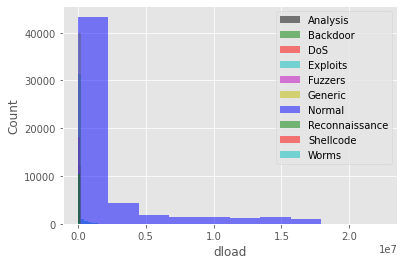

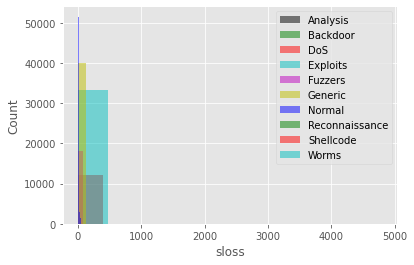

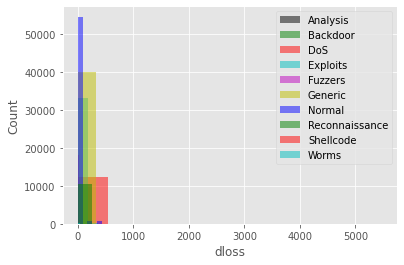

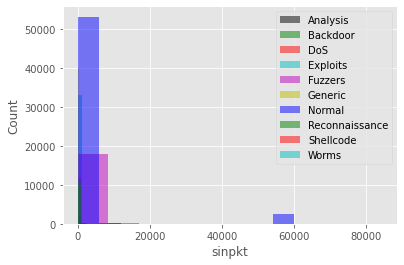

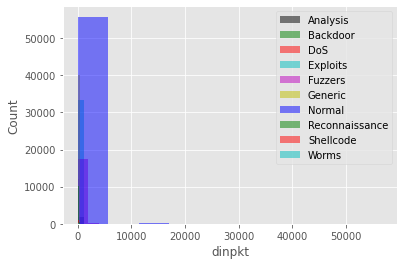

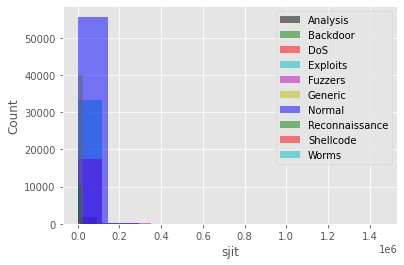

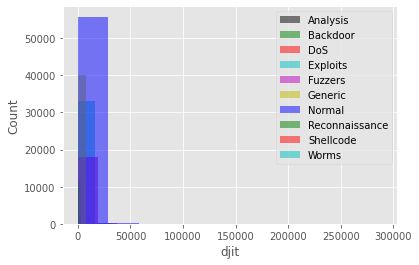

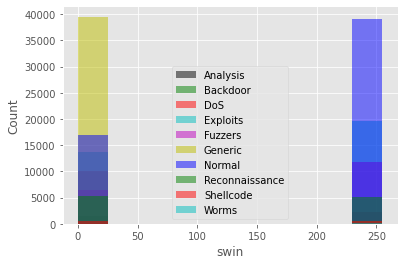

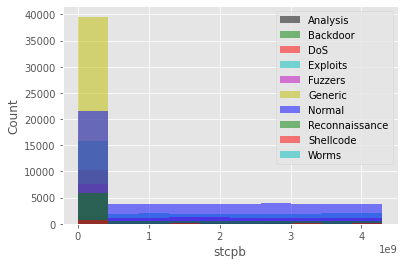

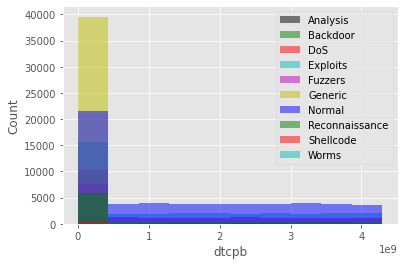

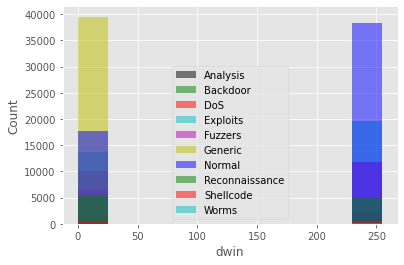

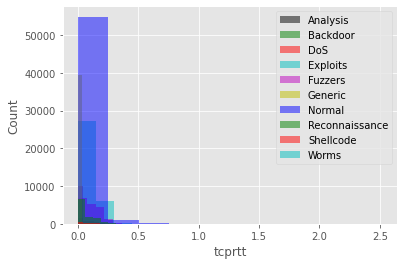

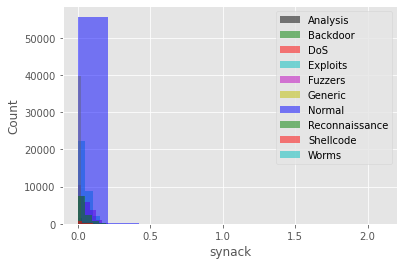

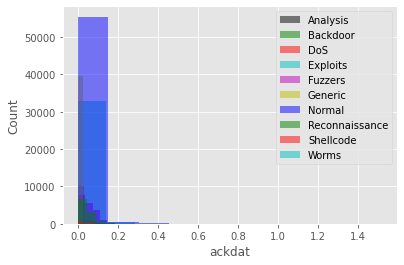

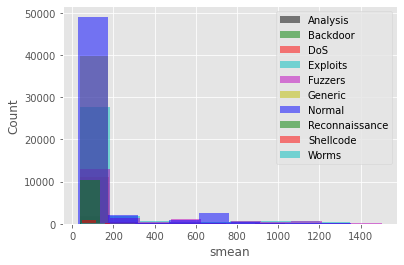

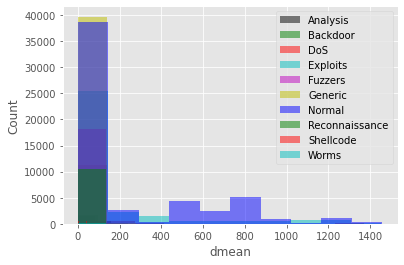

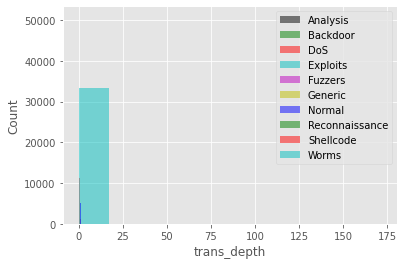

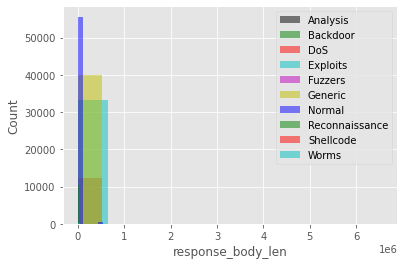

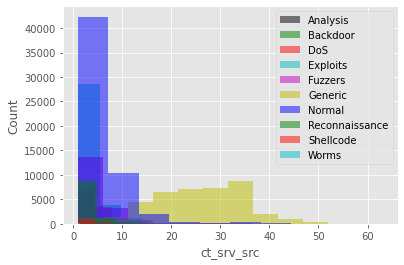

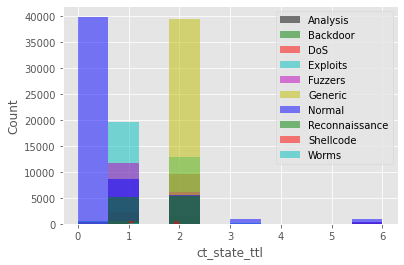

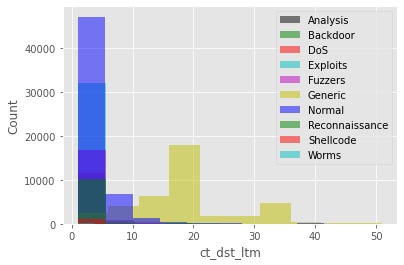

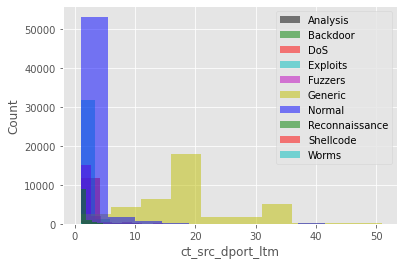

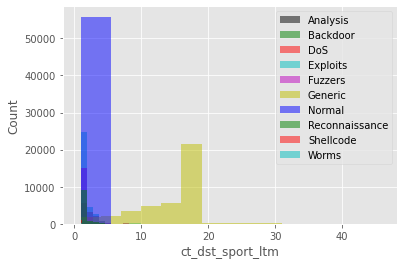

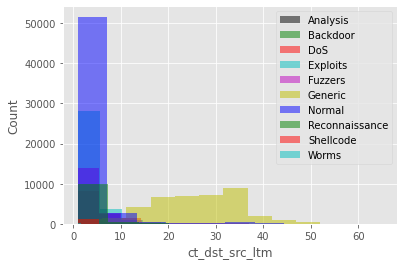

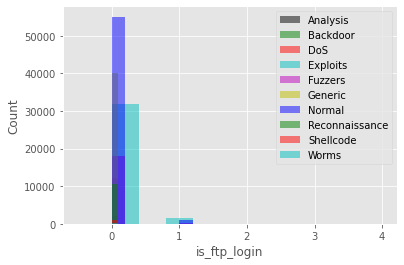

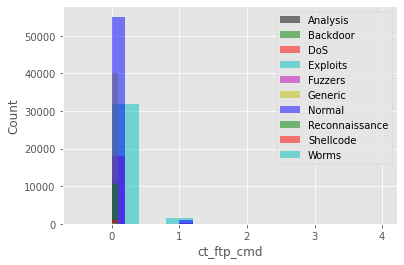

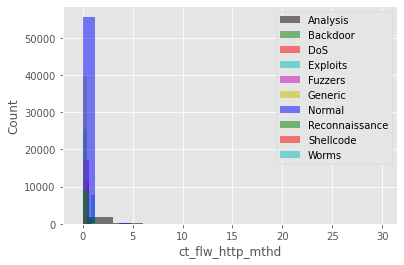

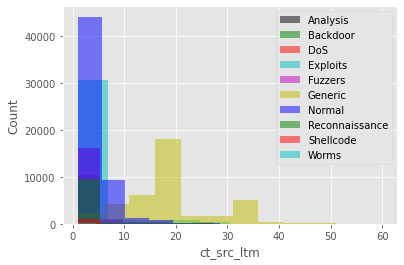

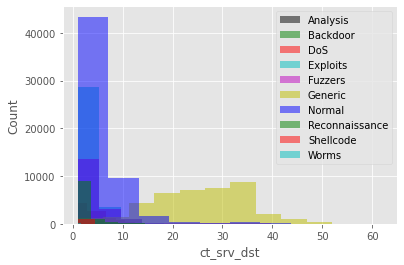

In [ ]:
cs = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'g', 'r', 'c']

i = 0
for feat in df_tr_feat.keys():
    plt.figure()
    for lbl in label_dict: 
        plt.hist(X[:,i][y==label_dict[lbl]], color=cs[label_dict[lbl]], alpha=.5, label=lbl)
    plt.xlabel(feat)
    plt.ylabel('Count')
    plt.legend()
    plt.savefig(code_path+'figs/feature_'+feat+'_distribution.pdf')

    i += 1

In [ ]:
scaler = preprocessing.StandardScaler().fit(X)
Xs = scaler.transform(X)
C = np.cov(Xs.T)

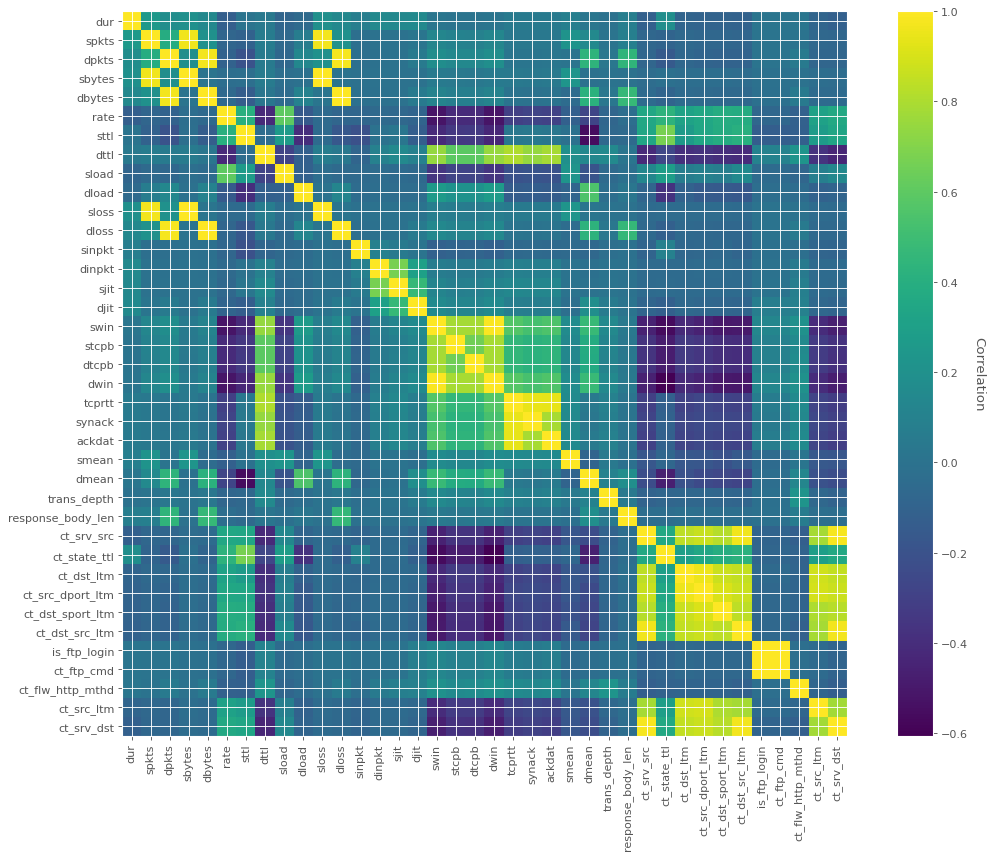

In [ ]:
fig, ax = plt.subplots(figsize=(16, 12), dpi=80)
im = ax.imshow(C)


cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Correlation', rotation=-90, va="bottom")
    
    
# We want to show all ticks...
ax.set_xticks(np.arange(len(df_tr_feat.keys())))
ax.set_yticks(np.arange(len(df_tr_feat.keys())))
# ... and label them with the respective list entries
ax.set_xticklabels(df_tr_feat.keys(), rotation=90)
ax.set_yticklabels(df_tr_feat.keys())
plt.savefig(code_path+'figs/covariance.pdf')


# Mutual information analysis

In [ ]:
df_tr = pd.read_csv(data_path + 'UNSW_NB15_training-set.csv')

drop_cols = ['id', 'proto', 'service', 'state', 'attack_cat', 'label', 'is_sm_ips_ports']
# drop_cols = ['id', 'proto', 'service', 'state', 'attack_cat', 'label']

df_tr_feat = df_tr.drop(drop_cols, axis = 1)
X = df_tr_feat.values
labels = df_tr['attack_cat'].values
y = np.zeros((len(X),))

uni_labels = np.unique(labels)
label_dict = {}
for lbl, n in zip(uni_labels, range(len(uni_labels))):
    label_dict[lbl] = n
label_dict['Analysis'] = 6
label_dict['Normal'] = 0


for n in range(len(y)): 
    y[n] = label_dict[labels[n]]

yb = y.copy()
yb[y!=0] = 1.

## Multi-Class

In [ ]:
mis_mc = mutual_info_classif(X, y)

## Binary Classes


In [ ]:
mis_mb = mutual_info_classif(X, yb)

## Sorted by Binary Classes 

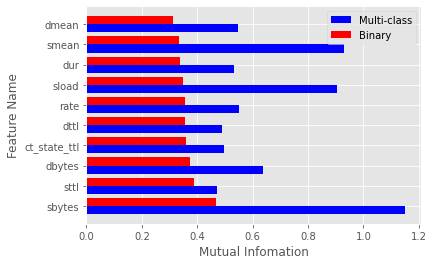

In [ ]:
#
T = 10
feats = df_tr_feat.keys()

f_ranks = np.argsort(mis_mb)[::-1]
mis_mc = mis_mc[f_ranks][:T]
mis_mb = mis_mb[f_ranks][:T]
feats_mb = feats[f_ranks][:T]


index = np.arange(len(feats_mb))-1
bar_width = 0.4
opacity = 1.

rects1 = plt.barh(index,  mis_mc, bar_width, alpha=opacity, color='b', label='Multi-class')
rects2 = plt.barh(index + bar_width,  mis_mb, bar_width, alpha=opacity, color='r', label='Binary')

plt.yticks(index + .5*bar_width, tuple(feats_mb))
plt.ylabel('Feature Name')
plt.xlabel('Mutual Infomation')
plt.legend(loc='upper right')



## Sorted by Multiclass

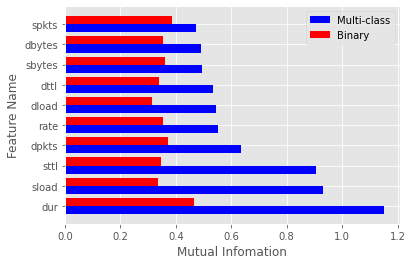

In [ ]:
T = 10
feats = df_tr_feat.keys()

f_ranks = np.argsort(mis_mc)[::-1]
mis_mc = mis_mc[f_ranks][:T]
mis_mb = mis_mb[f_ranks][:T]
feats_mc = feats[f_ranks][:T]


index = np.arange(len(feats_mc))-1
bar_width = 0.4
opacity = 1.

rects1 = plt.barh(index,  mis_mc, bar_width, alpha=opacity, color='b', label='Multi-class')
rects2 = plt.barh(index + bar_width,  mis_mb, bar_width, alpha=opacity, color='r', label='Binary')

plt.yticks(index + .5*bar_width, tuple(feats_mc))
plt.ylabel('Feature Name')
plt.xlabel('Mutual Infomation')
plt.legend(loc='upper right')

In [ ]:
feats_mc, feats_mb = set(feats_mc), set(feats_mb)
idx_jaccard = len(feats_mc.intersection(feats_mb))/len(feats_mc.union(feats_mb))
print('Jaccard Index: ' + str(idx_jaccard))

Jaccard Index: 0.5384615384615384
